# 1. Exploratory Data Analysis

In [2]:
import csv
import numpy as np
import nltk
import collections
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import nltk as nlp
import warnings
import sys
import os
import re
from nltk.probability import FreqDist
import seaborn as sns
from sklearn.metrics import  accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from keras import optimizers, Sequential
from keras.layers import LSTM, Dropout, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, RepeatVector, dot, Activation, multiply, concatenate, Flatten, Permute, merge, Embedding
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [3]:
from keras.layers import SpatialDropout1D, Bidirectional, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['LSTM_attention_HAO.ipynb',
 'ExtractedTweets.csv',
 'glove.6B.100d.txt',
 'Colab Notebooks',
 'repo-zou00080.zip',
 'CS Master PhD.gdoc',
 'ad_tweets.csv',
 'model_plot.png']

## 1.1 WordCloud

Dataset: SuperBowl

In [ ]:
tweet = []
# souperbowl dataset
for line in open('/content/drive/My Drive/ad_tweets.csv', 'r'):
    tweet.append(line.strip())

In [ ]:
tweet[0]

',tweet_text,tweet_text_clean,user_id,gender,ad_predicted,ad_type,ad_target,url_free_tweets,lemmas_back_to_text,hashtags,mentions,tidy_tweet'

In [ ]:
tweet[50]

'40,Charlie Day: Super Bowl MVP,charlie day super bowl mvp,1325746807,male,Tide Finally later,conforming ad,men,Charlie Day: Super Bowl MVP,charlie day super bowl mvp,,,charlie day super bowl mvp'

In [18]:
with open('/content/drive/My Drive/ad_tweets.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    column = [row['tweet_text_clean'] for row in reader]
print(column[0])

abiratchford damn sexy tide pod might add b


In [20]:
from wordcloud import STOPWORDS
tweet_list = []

for t in column:
    t = nltk.word_tokenize(t) # split sentences into word
    t = [word for word in t if not word in STOPWORDS] # remove the stopwords
    t = " ".join(t)
    tweet_list.append(t)

In [23]:
comments = ''
for n in range(len(tweet_list)):
    comments = comments + (str(tweet_list[n])).strip()

In [ ]:
tweets = collections.Counter(comments.split())

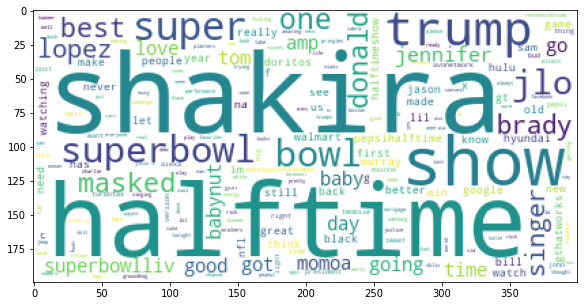

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

w = WordCloud(background_color="white",max_font_size=80)
w.generate_from_frequencies(tweets)
plt.imshow(w)

## 1.2 Political Affiliation

Dataset: Congressional Election

This dataset contains the tweet ids of 86,460 tweets related to the 2018 U.S. Congressional Election. They were collected between January 22, 2018 and January 3, 2019
https://towardsdatascience.com/are-you-democrat-or-republican-let-your-tweets-define-you-4aa4cadf4bea

In [5]:
df = pd.read_csv("/content/drive/My Drive/ExtractedTweets.csv")
df.dropna(axis = 0, inplace = True)

In [6]:
df["Party_log"] = [1 if each == "Democrat" else 0 for each in df.Party]
print(df.shape)
df.head()

(86460, 4)


,Party,Handle,Tweet,Party_log
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",1
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,1
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,1
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,1
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,1


In [ ]:
df.Party.value_counts()

Republican    44392
Democrat      42068
Name: Party, dtype: int64

In [7]:
democrat=df[df.Party=="Democrat"]
republican=df[df.Party=="Republican"]

In [8]:
STOPWORDS.add("rt")
STOPWORDS.add("s")
STOPWORDS.add("u")
STOPWORDS.add("amp")
STOPWORDS.add("th")
STOPWORDS.add("will")
STOPWORDS.add("t")
STOPWORDS.add("m")

In [11]:
democrat_list=[]
for d in democrat.Tweet:
    d=re.sub(r'http\S+', '', d) 
    d=re.sub("[^a-zA-Z]", " ", d) 
    d=d.lower() 
    d=nltk.word_tokenize(d) # split sentences into word
    d=[word for word in d if not word in STOPWORDS] 
    lemma=nlp.WordNetLemmatizer() 
    d=[lemma.lemmatize(word) for word in d] # identify the correct form of the word in the dictionary
    d=" ".join(d)
    democrat_list.append(d)

In [10]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [12]:
republican_list=[]
for r in republican.Tweet:
    r=re.sub(r'http\S+', '', r)
    r=re.sub("[^a-zA-Z]", " ", r)
    r=r.lower()
    r=nltk.word_tokenize(r)
    r=[word for word in r if not word in STOPWORDS]
    lemma=nlp.WordNetLemmatizer()
    r=[lemma.lemmatize(word) for word in r]
    r=" ".join(r)
    republican_list.append(r)

In [13]:
democrat_tweets=str(democrat_list).split()
democrat_tweets=[word.replace("'","") for word in democrat_tweets ]
democrat_tweets=[word.replace("[", "") for word in democrat_tweets ]
democrat_tweets=[word.replace("]","") for word in democrat_tweets ]
democrat_tweets=[word.replace(",", "") for word in democrat_tweets ]

republican_tweets=str(republican_list).split()
republican_tweets=[word.replace("'","") for word in republican_tweets ]
republican_tweets=[word.replace("[", "") for word in republican_tweets ]
republican_tweets=[word.replace("]","") for word in republican_tweets ]
republican_tweets=[word.replace(",", "") for word in republican_tweets ]

In [ ]:
print("Democrat tweets word length:",len(democrat_tweets))
print("Republican tweets word length:",len(republican_tweets))

Democrat tweets word length: 446201
Republican tweets word length: 459829


In [14]:
fdist_democrat = FreqDist(democrat_tweets)
fdist_republican=FreqDist(republican_tweets)

Text(0.5, 1.0, "Democrats' 15 most used words")

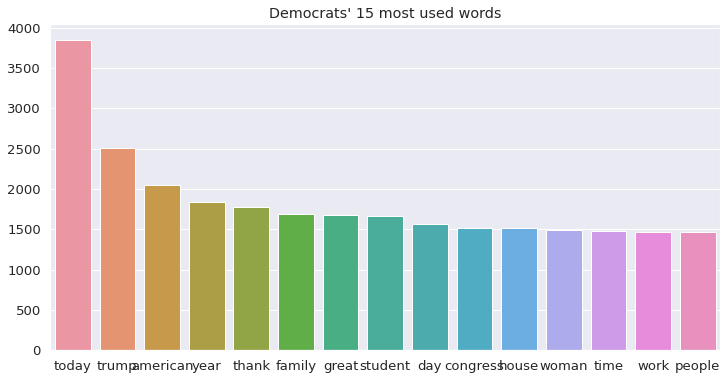

In [ ]:
Dem_freqw=pd.Series(fdist_democrat).sort_values(ascending=False).head(15)
Rep_freqw=pd.Series(fdist_republican).sort_values(ascending=False).head(15)

sns.set_style("white")
sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
sns.barplot(x=Dem_freqw.index, y=Dem_freqw).set_title("Democrats' 15 most used words")

Text(0.5, 1.0, "Republicans' 15 most used words")

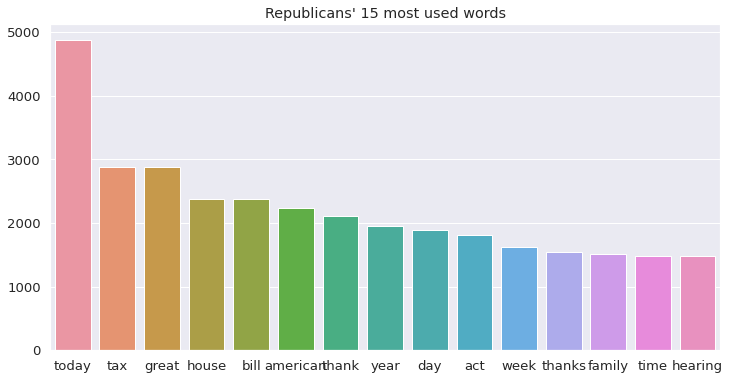

In [ ]:
sns.set_style("white")
sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
sns.barplot(x=Rep_freqw.index, y=Rep_freqw).set_title("Republicans' 15 most used words")

# 2. Deep Learning Models

## 2.1 Preprocessing

In [ ]:
print("Democrat tweets word length:",len(democrat_tweets))
print("Republican tweets word length:",len(republican_tweets))

Democrat tweets word length: 446201
Republican tweets word length: 459829


In [13]:
tweets = democrat_tweets + republican_tweets

In [ ]:
len(tweets)

906030

### 2.1.1 Stemming & Lemmatisation

In [14]:
# nltk.PorterStemmer() & nltk.LancasterStemmer()
st = nltk.LancasterStemmer()

def token(text):
    txt = nltk.word_tokenize(text.lower())
    return [st.stem(word) for word in txt]

### 2.1.2 CounterVectorizer & TF-IDF(TfidTransformer)

In [15]:
cv = CountVectorizer(lowercase=True, 
                     tokenizer=token, 
                     analyzer=u'word', min_df=4) # stop_words=STOPWORDS

In [16]:
X = cv.fit_transform(tweets)

In [ ]:
X.shape

(906030, 10970)

In [ ]:
feature_name = cv.get_feature_names()

In [ ]:
len(feature_name) # features

10970

In [ ]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)

In [ ]:
tfidf.shape

(906030, 10970)

In [ ]:
X = tfidf

In [ ]:
X_train, X_test = train_test_split(X, test_size=0.3, train_size=0.7, random_state=14)
X_train, X_valid = train_test_split(X_train, test_size=0.3, train_size=0.7, random_state=14)
X_train.shape, X_valid.shape

((443954, 10970), (190267, 10970))

In [ ]:
# samples, timesteps(max_length), features
samples = X.shape[0]
features = X.shape[1]
timesteps = 300

## 2.2 Training Models

### 2.2.1 LogisticRegression

In [ ]:
vec_train.shape, train.shape

((60521, 11053), (60521, 4))

In [ ]:
lr = LogisticRegression()
lr.fit(X = vec_train, y = train['Party_log'])

y_pred_lr=lr.predict(vec_test)
accuracy_score(y_pred_lr, test['Party_log'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7862980954584008

### 2.2.* Word to Vector Considering the Context)

In [ ]:
X = democrat_list + republican_list

In [ ]:
len(X)

86460

In [ ]:
X_train, X_test = train_test_split(X, test_size=0.3, train_size=0.7, random_state=14)
# X_train, X_valid = train_test_split(X_train, test_size=0.3, train_size=0.7, random_state=14)

In [ ]:
y = df['Party_log']

In [ ]:
y = np.array(list(map(lambda x: 1 if x==1 else 0, y)))

In [ ]:
y_train, y_test = train_test_split(y, test_size=0.3, train_size=0.7, random_state=14)
# y_train, y_valid = train_test_split(y_train, test_size=0.3, train_size=0.7, random_state=14)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# each list corresponds to each sentence in the training set
# the size of each list is different since sentences have different lengths
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
len(X_train)

60521

In [ ]:
# set the maximum size of each list to 100
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
vocab_size
# our corpus has 44300 unique words

44300

In [ ]:
# create the feature matrix
# https://nlp.stanford.edu/projects/glove/
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# the matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in the corpus
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### 2.2.2 LR (Consider the Context)

In [ ]:
lr = LogisticRegression()
lr.fit(X = X_train, y = y_train)

y_pred_lr=lr.predict(X_test)
accuracy_score(y_pred_lr, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5207417688333719

### 2.2.3 CNN

In [ ]:
from keras.layers import Conv1D

In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          4430000   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 4,494,257
Trainable params: 64,257
Non-trainable params: 4,430,000
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
379/379 [==============================] - 3s 7ms/step - loss: 0.6342 - acc: 0.6297 - val_loss: 0.6058 - val_acc: 0.6572
Epoch 2/6
379/379 [==============================] - 2s 6ms/step - loss: 0.5571 - acc: 0.7087 - val_loss: 0.5993 - val_acc: 0.6689
Epoch 3/6
379/379 [==============================] - 2s 6ms/step - loss: 0.5010 - acc: 0.7553 - val_loss: 0.5850 - val_acc: 0.6772
Epoch 4/6
379/379 [==============================] - 2s 6ms/step - loss: 0.4497 - acc: 0.7900 - val_loss: 0.5923 - val_acc: 0.6876
Epoch 5/6
379/379 [==============================] - 2s 6ms/step - loss: 0.3991 - acc: 0.8237 - val_loss: 0.6314 - val_acc: 0.6727
Epoch 6/6
811/811 [==============================] - 2s 3ms/step - loss: 0.6685 - acc: 0.6738


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6685475707054138
Test Accuracy: 0.6738376021385193


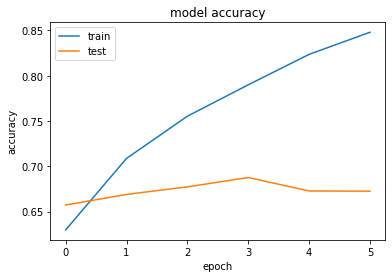

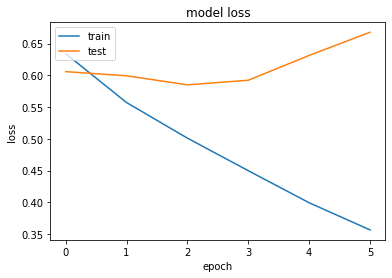

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

### 2.2.4 Simple LSTM

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          4430000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 4,547,377
Trainable params: 117,377
Non-trainable params: 4,430,000
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
379/379 [==============================] - 5s 14ms/step - loss: 0.6930 - acc: 0.5111 - val_loss: 0.6926 - val_acc: 0.5172
Epoch 2/6
379/379 [==============================] - 5s 12ms/step - loss: 0.6929 - acc: 0.5120 - val_loss: 0.6927 - val_acc: 0.5172
Epoch 3/6
379/379 [==============================] - 5s 13ms/step - loss: 0.6929 - acc: 0.5120 - val_loss: 0.6929 - val_acc: 0.5172
Epoch 4/6
379/379 [==============================] - 5s 12ms/step - loss: 0.6929 - acc: 0.5120 - val_loss: 0.6927 - val_acc: 0.5172
Epoch 5/6
379/379 [==============================] - 5s 12ms/step - loss: 0.6929 - acc: 0.5120 - val_loss: 0.6926 - val_acc: 0.5172
Epoch 6/6
811/811 [==============================] - 4s 5ms/step - loss: 0.6927 - acc: 0.5143


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6927414536476135
Test Accuracy: 0.5143033266067505


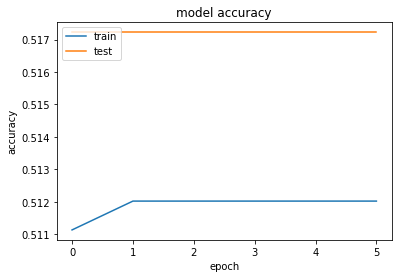

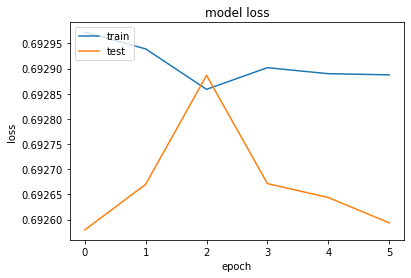

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### 2.2.5 LSTM with Autoencoder

In [ ]:
model = Sequential()
# encoder
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(100, activation='tanh', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(80, activation='tanh', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(20, activation='tanh', return_sequences=True))
# decoder
model.add(LSTM(100, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
# model.add(TimeDistributed(Dense(features, activation='sigmoid')))
model.add(Dropout(0.1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          4430000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 80)           57920     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 80)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 20)           8080      
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 100)         

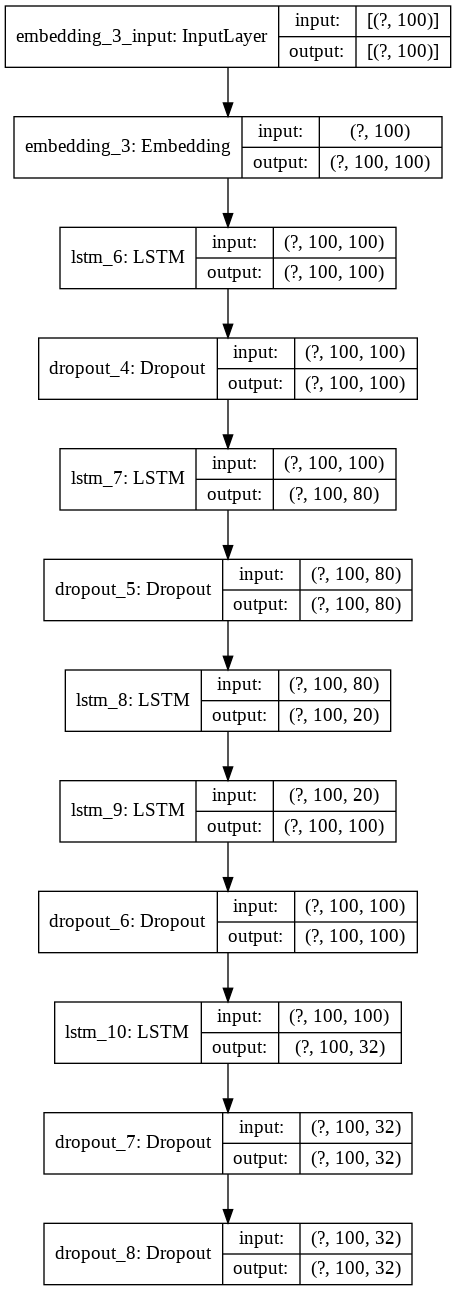

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
LR = 1e-3
N_EPOCHS = 20
BATCH_SIZE = 128

In [ ]:
X_train, X_valid = train_test_split(X_train, test_size=0.3, train_size=0.7, random_state=14)

In [ ]:
adam = optimizers.Adam(LR)

cp = ModelCheckpoint(filepath="/Users/zouhao/Desktop/DMRResearch/lstm_attention_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/Users/zouhao/Desktop/DMRResearch/Attention/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = model.fit(X_train, X_train, 
                                                epochs=N_EPOCHS, 
                                                batch_size=BATCH_SIZE, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
change = model.predict(X_train)
print(change.shape)

Epoch 1/20


ValueError: ignored

### LSTM with Attention

In [ ]:
X_train.shape

(42364, 100)

In [ ]:
# samples, features, timesteps
samples = 42364
timesteps = 100